<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/%5BFT%5DFasterRCNN_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook references:
1. PyTorch torchvision object detection tutorial: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
2. Daniel's FasterRCNN notebook: https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn

Thanks for both resources that making me learned how to use the pre-trained model for mask detection task.

Dataset:
Kaggle Face Mask Detection: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

# I. Preliminaries

## Import libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from random import randint
import time
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from matplotlib import pyplot as plt
from matplotlib import patches

from bs4 import BeautifulSoup

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
# This variable stores training Hypermeters
config = dict()

## Loading files

In [ ]:
# Download Kaggle Mask Detection Dataset
if not os.path.exists("/root/.kaggle/kaggle.json"):
    os.mkdir("/root/.kaggle")
    with open("/root/.kaggle/kaggle.json", "w+") as f:
        f.write('{"username":"###","key":"###"}') # Placing your Kaggle API here
        os.chmod("/root/.kaggle/kaggle.json", 600)
    
!kaggle datasets download -d andrewmvd/face-mask-detection
!unzip -qo "face-mask-detection.zip" -d "/content/data"

 96% 382M/398M [00:02<00:00, 196MB/s]
100% 398M/398M [00:03<00:00, 139MB/s]


In [ ]:
ROOT = "/content/data/"

In [ ]:
# store file paths
imgs = list(sorted(os.listdir(ROOT + "images/")))
annots = list(sorted(os.listdir(ROOT + "annotations/")))

## Inspect data

number of objects:  3


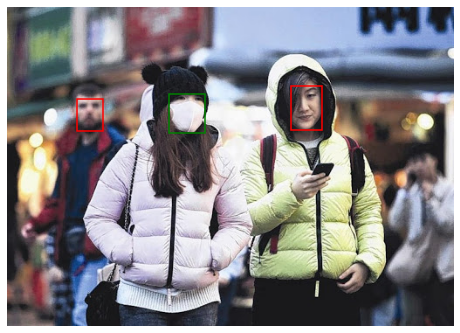

In [ ]:
# Read bounding box data
with open(ROOT + "annotations/" + annots[0], "r") as f:
    data = f.read()
    soup = BeautifulSoup(data, "xml")
    objects = soup.find_all("object")
    num_objs = len(objects) # Find the number of objects in the image
    print("number of objects: ", num_objs)
    
    test_boxes = []
    test_labels = []
    
    for obj in objects:
        # Getting corners
        x_min = int(obj.find("xmin").text)
        y_min = int(obj.find("ymin").text)
        x_max = int(obj.find("xmax").text)
        y_max = int(obj.find("ymax").text)
        corners = [x_min, y_min, x_max, y_max]
        test_boxes.append(corners)
        
        # Getting Labels
        label = obj.find("name").text
        if label == "with_mask": test_labels.append(1)
        elif label == "mask_weared_incorrect": test_labels.append(2)
        else: test_labels.append(0)

# Read image
test_img = Image.open(ROOT + "images/" + imgs[0])
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.axis(False)
ax.imshow(test_img)

for i, box in enumerate(test_boxes):
    x_min, y_min, x_max, y_max = box
    
    # If wear mask, show green rect, red is not wear, else blue
    color = "g"
    if test_labels[i] == 2: color = "b"
    elif test_labels[i] != 1: color = "r"
        
    rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                             linewidth=1.5, edgecolor=color, facecolor="none")
    ax.add_patch(rect)

# II. Dataset and DataLoader

### Helper functions for loading data

First, we need a function to get training data's bouding box, labels, and image id

In [ ]:
# return annots
def get_annot(annot_file) -> dict:
    with open(ROOT + "annotations/" + annot_file, "r") as f:
        data = f.read()
        soup = BeautifulSoup(data, "xml")
        objects = soup.find_all("object")
        num_objs = len(objects)
        
        bboxes = []
        labels = []
        img_id = 0
    
        for obj in objects:
            # Getting corners
            x_min = int(obj.find("xmin").text)
            y_min = int(obj.find("ymin").text)
            x_max = int(obj.find("xmax").text)
            y_max = int(obj.find("ymax").text)
            corners = [x_min, y_min, x_max, y_max]
            bboxes.append(corners)

            # Getting Labels
            """
            #################################################################
            IMPORTANT: In fasterRCNN, 0 is for background, 
                       so our label's index should start from 1!
            #################################################################
            """
            
            label = obj.find("name").text
            if label == "with_mask": labels.append(1)
            elif label == "mask_weared_incorrect": labels.append(2)
            else: labels.append(3)
            
            # Getting image id
            img_id = int(annot_file.split(".")[0][12:])
        
        return dict({"boxes": torch.tensor(bboxes), 
                     "labels": torch.LongTensor(labels), 
                     "image_id": torch.LongTensor(img_id)})
        

# return image
def get_img(img_file, transforms) -> torch.Tensor:
    img = Image.open(ROOT + "images/" + img_file).convert("RGB")
    return transforms(img)

The images are in PIL format; we should convert them to torch tensors for training

In [ ]:
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
            ])

### Dataset Class
Here we process the whole dataset when initializing it, to reduce loading/processing time in training

In [ ]:
class MaskDataset(Dataset):
    
    def __init__(self, img_files, annot_files, transforms):
        super(MaskDataset, self).__init__()
        self.length = len(img_files)
        assert self.length == len(annot_files)
        
        self.imgs = [get_img(img_files[i], transforms) for i in range(self.length)]
        self.targets = [get_annot(annot_files[i]) for i in range(self.length)]
        
    
    def __len__(self):
        return self.length
        
        
    def __getitem__(self, idx):
        return self.imgs[idx], self.targets[idx]

In [ ]:
# initialize mask dataset
mask_data = MaskDataset(imgs, annots, transforms)

A very important thing in evaluating our training outcome is how the model response to the **UNSEEN** data. So instead feeding all the data to the training process, we need to split the data into train, validation, and test partitions; train partition used to train the model, validation partition used to monitor the training process to avoid overfitting, and the test dataset used to evaluate the model's performance. The test data should have never been seen in the whole training process. <br>
However, as we are finetunning a pretrained model and we don't really have a very large dataset, so we just split the data into train and test part, and ignoring the validation. 

In [ ]:
# Randomly split data into train part and test part
train_data_ratio = 0.95

train_size = int(len(mask_data) * train_data_ratio)
test_size = len(mask_data) - train_size # test data shouldn't be appeared in training

train_data, test_data = torch.utils.data.random_split(mask_data, [train_size, test_size])

print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Train data size:  810
Test data size:  43


### Sanity Check

In [ ]:
# Sanity check
def plot_data(image, annots):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    im = image.permute(1, 2, 0)
    ax.imshow(im)
    
    bboxes, labels = annots["boxes"], annots["labels"]
    
    for i, box in enumerate(bboxes):
        x_min, y_min, x_max, y_max = box
        color = "g"
        if labels[i] == 2: color = "b"
        elif labels[i] == 3: color = "r"
        
        rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                                 linewidth=1.5, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.axis(False)
    plt.show()

Train Data:


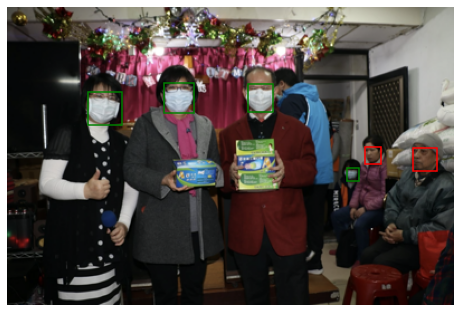

Test Data:


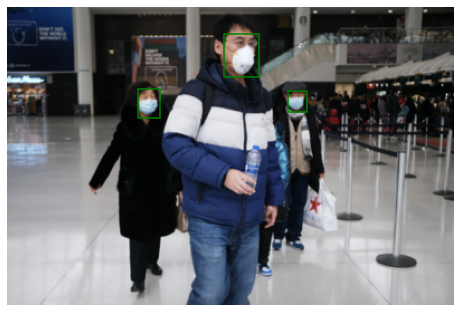

In [ ]:
print("Train Data:")
plot_data(*train_data[randint(0, len(train_data)-1)])
print("Test Data:")
plot_data(*test_data[randint(0, len(test_data)-1)])

### DataLoaders

In [ ]:
collate_fn = lambda batch: tuple(zip(*batch))

config["batch_size"] = 5 # This will require around 10G CUDA memory

train_loader = DataLoader(train_data, batch_size=config["batch_size"], 
                          shuffle=True, pin_memory=True, collate_fn=collate_fn)

# III. Model and Train Setups

In [ ]:
# Reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 4 # Background + 3 masking classes

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
config["epochs"] = 20

# The loss function is already built in the model, so we don't need to define it here

# Reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4,
                              amsgrad=True, 
                              weight_decay=1e-6)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.5)

scaler = torch.cuda.amp.GradScaler()

In [ ]:
# train function
def train(model, dataloader, optimizer):
    
    model.train()
    train_loss = 0
    
    # Showing a tqdm bar to visualiza the progress of a single pass
    batch_bar = tqdm(total=len(dataloader), position=0,
                     leave=False, dynamic_ncols=True, desc="Train")
    
    for i, (images, targets) in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        # Sending training data to CUDA
        images = list([image.to(DEVICE) for image in images])
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.cuda.amp.autocast():
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())
        
        train_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Updating tqdm bar information
        batch_bar.set_postfix(
            loss = f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.6f}"
        )
        
        batch_bar.update()
        
        # clear caches in the CUDA to avoid insufficient CUDA memory
        torch.cuda.empty_cache()
        del images, targets, loss_dict
    
    batch_bar.close()
    
    return train_loss / len(dataloader)

# IV Train and Test

### Training

In [ ]:
for i in range(config['epochs']):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer)
    
    # Step the scheduler
    lr_scheduler.step()
    
    print(f"Epoch {i+1}/{config['epochs']}\t train loss: {train_loss:.4f}\
            \t epoch time: {(time.time()-start_time)/60:.2f}\
            \t lr: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/20	 train loss: 0.4357            	 epoch time: 0.80            	 lr: 0.000100


Epoch 2/20	 train loss: 0.2790            	 epoch time: 0.65            	 lr: 0.000100


Epoch 3/20	 train loss: 0.2393            	 epoch time: 0.63            	 lr: 0.000100


Epoch 4/20	 train loss: 0.2051            	 epoch time: 0.65            	 lr: 0.000100


Epoch 5/20	 train loss: 0.1785            	 epoch time: 0.64            	 lr: 0.000050


Epoch 6/20	 train loss: 0.1404            	 epoch time: 0.64            	 lr: 0.000050


Epoch 7/20	 train loss: 0.1130            	 epoch time: 0.64            	 lr: 0.000050


Epoch 8/20	 train loss: 0.1000            	 epoch time: 0.64            	 lr: 0.000050


Epoch 9/20	 train loss: 0.0891            	 epoch time: 0.64            	 lr: 0.000050


Epoch 10/20	 train loss: 0.0870            	 epoch time: 0.64            	 lr: 0.000025


Epoch 11/20	 train loss: 0.0718            	 epoch time: 0.64            	 lr: 0.000025


Epoch 12/20	 train loss: 0.0565            	 epoch time: 0.63            	 lr: 0.000025


Epoch 13/20	 train loss: 0.0509            	 epoch time: 0.64            	 lr: 0.000025


Epoch 14/20	 train loss: 0.0476            	 epoch time: 0.63            	 lr: 0.000025


Epoch 15/20	 train loss: 0.0465            	 epoch time: 0.64            	 lr: 0.000013


Epoch 16/20	 train loss: 0.0407            	 epoch time: 0.64            	 lr: 0.000013


Epoch 17/20	 train loss: 0.0355            	 epoch time: 0.63            	 lr: 0.000013


Epoch 18/20	 train loss: 0.0332            	 epoch time: 0.64            	 lr: 0.000013


Epoch 19/20	 train loss: 0.0316            	 epoch time: 0.63            	 lr: 0.000013


Epoch 20/20	 train loss: 0.0307            	 epoch time: 0.64            	 lr: 0.000006


### Test on a single image

Target: 
tensor([1, 1, 1])


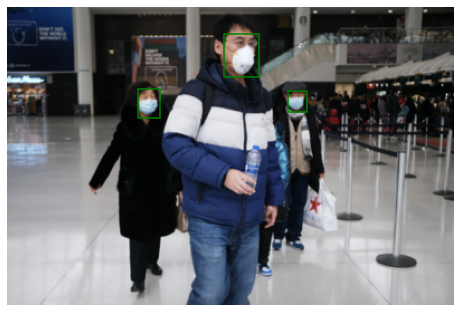

Prediction: 
tensor([1, 1, 1, 3])


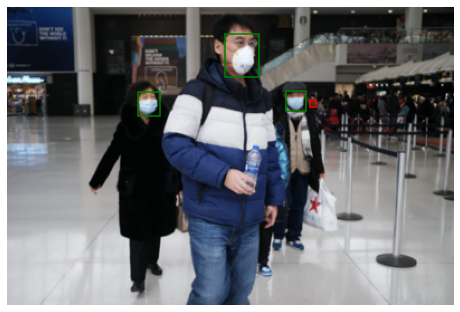

In [ ]:
# We randomly sample data from the test dataset
image, target = test_data[randint(0, len(test_data)-1)]

model.eval() # Turn the model to evaluation mode

image_cuda = [image.to(DEVICE)]
target_cuda = [{k: v.to(DEVICE) for k, v in target.items()}]

with torch.no_grad():
    preds = model(image_cuda, target_cuda)
    
preds = [{k:v.detach().cpu() for k, v in p.items()} for p in preds]

print(f"Target: \n{target['labels']}")
plot_data(image, target)
print(f"Prediction: \n{preds[0]['labels']}")
plot_data(image, preds[0])

torch.cuda.empty_cache()
del image, target, preds, image_cuda, target_cuda